### Script to find good pairs for each subject
Criteria: 
- For each pair of features, find sessions where the pairs of features each show up least N blocks as rules per session 
- Find pairs of features which have at least M sessions that satisfy this condition. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *

import seaborn as sns
import scipy.stats


In [2]:
num_bins = 2

def get_sess_beh(row, beh_path, sub):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_beliefs_per_session(beh, session, sub)
    beh = behavioral_utils.get_belief_value_labels(beh)
    beh["session"] = session
    return beh

### Load behavior based on subject

In [3]:
sub = "SA"

if sub == "SA":
    # Monkey S
    SESSIONS_PATH = "/data/patrick_res/sessions/SA/valid_sessions.pickle"
    sessions = pd.read_pickle(SESSIONS_PATH)
    beh_path = SESS_BEHAVIOR_PATH
    all_beh = pd.concat(sessions.apply(lambda x: get_sess_beh(x, beh_path, "SA"), axis=1).values).reset_index()
elif sub == "BL":
    # Monkey B
    # all_units = pd.read_pickle("/data/patrick_res/firing_rates/BL/all_units.pickle")
    # sessions = pd.DataFrame({"session_name": all_units.session.unique()})
    sessions = pd.read_pickle("/data/patrick_res/sessions/BL/valid_sessions.pickle")
    all_beh = pd.concat(sessions.apply(lambda x: get_sess_beh(x, BL_SESS_BEHAVIOR_PATH, "BL"), axis=1).values).reset_index()
else: 
    raise ValueError()

In [4]:
sub = all_beh[["TrialNumber", "BeliefStateValue"]]

In [5]:
block_thresh = 3

In [6]:
pairs = behavioral_utils.get_good_pairs_across_sessions(all_beh, block_thresh)
pairs.sort_values(by="num_sessions", ascending=False)[:20]

,pair,sessions,num_sessions,dim_type
0,"[CIRCLE, SQUARE]","[20180615, 20180709, 20180802, 20180803, 20180...",14,within dim
40,"[CYAN, YELLOW]","[20180705, 20180801, 20180802, 20180820, 20180...",14,within dim
6,"[CIRCLE, YELLOW]","[20180802, 20180810, 20180813, 20180821, 20180...",13,across dim
46,"[GREEN, YELLOW]","[20180802, 20180813, 20180829, 20180904, 20180...",12,within dim
16,"[SQUARE, YELLOW]","[20180801, 20180802, 20180810, 20180820, 20180...",12,across dim
13,"[SQUARE, CYAN]","[20180801, 20180802, 20180803, 20180820, 20180...",11,across dim
51,"[MAGENTA, YELLOW]","[20180705, 20180801, 20180802, 20180820, 20180...",11,within dim
56,"[YELLOW, ESCHER]","[20180810, 20180813, 20180820, 20180821, 20180...",11,across dim
58,"[YELLOW, RIPPLE]","[20180705, 20180802, 20180810, 20180821, 20180...",11,across dim
15,"[SQUARE, MAGENTA]","[20180801, 20180802, 20180803, 20180806, 20180...",11,across dim


In [13]:
good_sess = pairs[pairs.num_sessions >=3].sessions.explode()

In [15]:
all_units = pd.read_pickle("/data/patrick_res/firing_rates/SA/all_units.pickle")

good_sess[good_sess.isin(all_units.session.unique())]

0     20180615
0     20180709
0     20180802
0     20180803
0     20180806
        ...   
65    20180802
65    20180803
65    20180810
65    20180817
65    20180921
Name: sessions, Length: 526, dtype: object

In [8]:
session_thresh = 10

In [9]:
good_pairs = pairs[pairs.num_sessions >= session_thresh]

In [18]:
len(good_pairs)

17

In [19]:
len(good_pairs[good_pairs.dim_type == "within dim"])

6

In [7]:
good_pairs

NameError: name 'good_pairs' is not defined

In [20]:
# good_pairs.to_pickle("/data/patrick_res/sessions/pairs_at_least_3blocks_7sess.pickle")
good_pairs.to_pickle(f"/data/patrick_res/sessions/{sub}/pairs_at_least_{block_thresh}blocks_{session_thresh}sess.pickle")

### For each session, for each pair, what are the min number of trials that match: 
- high preferred features
- high conf trials where features are chosen but not preferred. 

In [10]:
high_val_only = False
def min_trials_per_session(row):
    res = []
    for sess in row.sessions:
        beh = all_beh[all_beh.session == sess]

        # find minimum number of trials, when either features are preferred
        # pref_beh = beh[beh.BeliefStateValueLabel.isin([f"High {feat1}", f"High {feat2}"])]
        # min_pref = np.min(pref_beh.groupby("BeliefStateValueLabel").count().TrialNumber)

        pref_chose = behavioral_utils.get_chosen_preferred_trials(row.pair, beh, high_val_only)
        min_pref_chose = np.min(pref_chose.groupby("Choice").count().TrialNumber)


        not_pref_chose = behavioral_utils.get_chosen_not_preferred_trials(row.pair, beh, high_val_only)

        min_not_pref = np.min(not_pref_chose.groupby("Choice").count().TrialNumber)

        res.append({
            "pair": row.pair, 
            "session": sess, 
            "min_pref_chose": min_pref_chose,
            "min_not_pref_chose": min_not_pref,
            "min_all": np.min((min_pref_chose, min_not_pref))
        })
    return pd.DataFrame(res)
        
min_trials = pd.concat(good_pairs.apply(min_trials_per_session, axis=1).values)



array([[<Axes: title={'center': 'min_pref_chose'}>,
        <Axes: title={'center': 'min_not_pref_chose'}>],
       [<Axes: title={'center': 'min_all'}>, <Axes: >]], dtype=object)

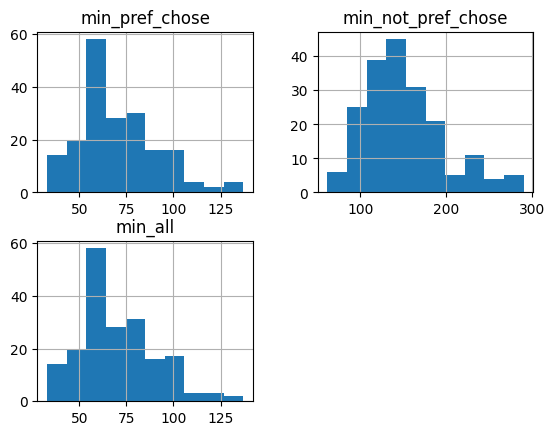

In [12]:
min_trials.sort_values(by="min_all").hist()

In [18]:
# min_trials.to_pickle("/data/patrick_res/sessions/SA/pairs_at_least_3blocks_7sess_min_trials.pickle")
# min_trials.to_pickle("/data/patrick_res/sessions/SA/pairs_at_least_3blocks_10sess_more_sess.pickle")


In [18]:
min_trials_original = pd.read_pickle("/data/patrick_res/sessions/pairs_at_least_3blocks_7sess_min_trials.pickle")

In [23]:
(min_trials_original.min_all - min_trials.min_all).sum()

78